In [2]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn import pipeline
import numpy as np,pandas as pd

pipeline.Pipeline(steps=[(),(),()])

val= np.exp(np.array([list(range(1,30))]))

from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression

def log_transform(x):
    return np.log(x+1)

scaler = StandardScaler()
trns = FunctionTransformer(log_transform)
reg = LinearRegression()

pipe = pipeline.Pipeline(
    steps=[
        ('scaler',scaler),
        ('transformer',trns),
        ('regressor',reg)
    ]
)

In [7]:
product_data = pd.read_csv('../data/master_product_list.csv')
product_data['prodSiteID'] = product_data['prodSiteID'].str.upper()
review_data = pd.read_csv('../data/all_reviews_without_unicode.csv')
review_data['prodSiteID'] = review_data['prodSiteID'].str.upper()
review_data = review_data.merge(
    right=pd.DataFrame(
      product_data[
        [
            'product_price','prodSiteID',
            'prod_subjectivity','total_star_rating','site','total_reviews'
        ]
      ]
    ),
    on='prodSiteID',
    how='left'
)

review_data['is_helpful'] = np.select(
    [
        review_data['review_helpful_votes'] > 0,
        review_data['review_helpful_votes'] == 0 | review_data['review_helpful_votes'].isna(),
    ],
    [
        1,
        0
    ]
)

review_data_base = pd.DataFrame(review_data)

review_data = pd.DataFrame(
    review_data[
        (review_data['productID'].isin([1,2,3,5,6,8,9,11,12,13,14,15])) &
        (review_data['review_lang']=='en')
    ]
)

review_metrics = pd.read_csv('../data/combined_review_metrics.csv')


t = pd.DataFrame(review_data[review_data['site_outlier']==0])
t['site'] = np.select(
    [
        t['site_x']=='Amazon',
        t['site_x']=='BestBuy',
        t['site_x']=='Target'
    ],
    [
        1/3,2/3,1
    ]
)
az_votes,bb_votes,tg_votes = (
    t[t['site_x']=='Amazon']['review_helpful_votes'],
    t[t['site_x']=='BestBuy']['review_helpful_votes'],
    t[t['site_x']=='Target']['review_helpful_votes']
)


C:\Users\pconn\AppData\Local\Temp\ipykernel_32004\3230024093.py:3: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  review_data = pd.read_csv('../data/all_reviews_without_unicode.csv')


In [17]:
t.head()

,productID,prodSiteID,review_header,reviewer_name,review_content,review_star_rating,review_helpful_votes,verified_purchase,review_subjectivity,review_polarity,...,site_outlier_en,global_outlier,global_outlier_en,product_price,prod_subjectivity,total_star_rating,site_y,total_reviews,is_helpful,site
0,1,AMAZON1,It is renewed but looked like new,Andre,"It was packaged very well, Amazon packaging, n...",5,1,True,0.588232,0.258266,...,0,0,0,664.71,0.497845,4.2,amazon,101.0,1,0.333333
1,1,AMAZON1,Worth it,Alice,"The phone came in perfect conditions, without ...",5,2,True,0.430909,0.447273,...,0,0,0,664.71,0.497845,4.2,amazon,101.0,1,0.333333
2,1,AMAZON1,Amazon Warehouse for the Win!,Mrs. K,I got a great deal on this at Amazon Warehouse...,5,2,True,0.554959,0.394215,...,0,0,0,664.71,0.497845,4.2,amazon,101.0,1,0.333333
4,1,AMAZON1,Like new iPhone 14,Rick,The iPhone 14 came with a battery that had 100...,5,0,True,0.636364,0.424242,...,0,0,0,664.71,0.497845,4.2,amazon,101.0,0,0.333333
5,1,AMAZON1,Better than new!,Love to sleep,This is my second iPhone purchase from Amazon ...,5,0,True,0.613068,0.402557,...,0,0,0,664.71,0.497845,4.2,amazon,101.0,0,0.333333


In [9]:
t.columns

# we want review length, compound sentiment (just the polarity?), total votes (on the product), review length, total star rating for the product



Index(['productID', 'prodSiteID', 'review_header', 'reviewer_name',
       'review_content', 'review_star_rating', 'review_helpful_votes',
       'verified_purchase', 'review_subjectivity', 'review_polarity',
       'review_length', 'url', 'review_lang', 'site_x', 'site_outlier',
       'site_outlier_en', 'global_outlier', 'global_outlier_en',
       'product_price', 'prod_subjectivity', 'total_star_rating', 'site_y',
       'total_reviews', 'is_helpful', 'site'],
      dtype='object')

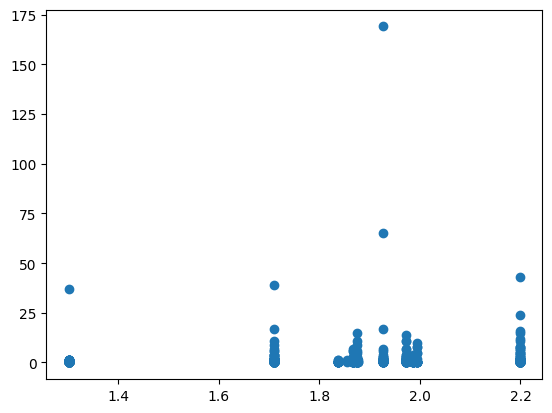

In [23]:
X_train,X_test,y_train,y_test = train_test_split(
    t[t['site_y']=='amazon'][[
        #'review_subjectivity','review_polarity','site','prod_subjectivity','review_length'#'site'#,'product_price'
        #'review_polarity',
        'total_star_rating',
        'total_reviews'
        #,'review_length'
    ]],
    #appears exponentially distributed - take the log!
    #np.log(t['review_helpful_votes']+1)
    t[t['site_y']=='amazon']['review_helpful_votes']
)

# y_train,y_test = [
#     (y_train-np.mean(y_train))/np.std(y_train),
#     (y_test-np.mean(y_test))/np.std(y_test)
# ]

mod = LinearRegression().fit(X_train,y_train)
y_pred = mod.predict(X_test)

real_pred = pd.DataFrame({'observed':y_test,'predicted':y_pred})

import seaborn as sns
#sns.scatterplot(data=real_pred,x='observed',y='predicted')
y_test.describe()
import matplotlib.pyplot as plt
plt.scatter(
    y_pred,y_test
)



























asdfd asdfasfd s



asdf asdfas f


asdf asdfa sdf dsa f


In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from textblob import TextBlob

product_data = pd.read_csv('../data/master_product_list.csv')

product_data['prod_subjectivity'] = product_data.apply(
    lambda row: TextBlob(str(row['product_details'])+' '+str(row['product_specs'])).subjectivity,  axis=1
)
product_data['prodSiteID'] = product_data['prodSiteID'].str.lower()
#review_data = pd.read_csv('../data/combined_review_table.csv')
review_data = pd.read_csv('../data/all_reviews_without_unicode.csv')
review_data['prodSiteID'] = review_data['prodSiteID'].str.lower()
review_data = review_data.merge(
    right=product_data[['prodSiteID','prod_subjectivity']],
    how='left',on='prodSiteID'
)

review_data_base = pd.DataFrame(review_data)
train_data = pd.DataFrame(
    review_data[
        (review_data['productID'].isin([1,2,3,5,6,8,9,11,12,13,14,15])) &
        (review_data['review_lang']=='en') & 
        (review_data['site_outlier']==0)
    ]
)
train_data['prodSiteID'] = train_data['prodSiteID'].str.lower()

# train_data = train_data.merge(
#     right=product_data[['prodSiteID','prod_subjectivity']],
#     how='left',on='prodSiteID'
# )

display(train_data)
# train_data['prod_subjectivity'] = train_data.apply(
#     lambda row: 
#         product_data[
#             product_data['prodSiteID']==row['prodSiteID']
#         ]['prod_subjectivity'].iloc[0],
#     axis=1
# )

test_data = pd.DataFrame(
    review_data[
        (review_data['review_lang']=='en') & 
        (~review_data['productID'].isin([1,2,3,5,6,8,9,11,12,13,14,15]))
    ]
)
# test_data = test_data.merge(
#     right=product_data[['prodSiteID','prod_subjectivity']],
#     how='left',on='prodSiteID'
# )
   
review_metrics = pd.read_csv('../data/combined_review_metrics.csv')

C:\Users\pconn\AppData\Local\Temp\ipykernel_31220\1902485603.py:15: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  review_data = pd.read_csv('../data/all_reviews_without_unicode.csv')


,Unnamed: 0,productID,prodSiteID,review_header,reviewer_name,review_content,review_star_rating,review_helpful_votes,verified_purchase,review_subjectivity,review_polarity,review_length,url,review_lang,site,site_outlier,site_outlier_en,global_outlier,global_outlier_en,prod_subjectivity
0,0,1,amazon1,It is renewed but looked like new,Andre,"It was packaged very well, Amazon packaging, n...",5,1,True,0.588232,0.258266,49.0,NaN,en,Amazon,0,0,0,0,0.497845
1,1,1,amazon1,Worth it,Alice,"The phone came in perfect conditions, without ...",5,2,True,0.430909,0.447273,24.0,NaN,en,Amazon,0,0,0,0,0.497845
2,2,1,amazon1,Amazon Warehouse for the Win!,Mrs. K,I got a great deal on this at Amazon Warehouse...,5,2,True,0.554959,0.394215,66.0,NaN,en,Amazon,0,0,0,0,0.497845
4,4,1,amazon1,Like new iPhone 14,Rick,The iPhone 14 came with a battery that had 100...,5,0,True,0.636364,0.424242,31.0,NaN,en,Amazon,0,0,0,0,0.497845
5,5,1,amazon1,Better than new!,Love to sleep,This is my second iPhone purchase from Amazon ...,5,0,True,0.613068,0.402557,54.0,NaN,en,Amazon,0,0,0,0,0.497845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47456,47456,15,bb15,Personal traveling cooler,Zaggxr,"This cooler is very nice, it is Judy what I ne...",5,0,True,0.650000,0.390000,11.0,NaN,en,BestBuy,0,0,0,0,0.422341
47457,47457,15,bb15,IMX,RobertbC,The best cooler I have owned! Great on fishing...,5,0,True,0.525000,0.900000,10.0,NaN,en,BestBuy,0,0,0,0,0.422341
47459,47459,15,bb15,Great cooler for the money,AlexanderM,Fantastic cooler! Held temp longer than advert...,5,0,True,0.825000,0.650000,7.0,NaN,en,BestBuy,0,0,0,0,0.422341
47461,47461,15,bb15,Keep it cool,Tyrone6133,Thos cooler hereis the truth keeping items col...,5,0,True,0.825000,-0.125000,10.0,NaN,en,BestBuy,0,0,0,0,0.422341


In [18]:
train_data[train_data['prod_subjectivity'].isna()]['prodSiteID'].unique()

array([], dtype=object)

In [74]:
# def dexp(data):
#     l = data.mean()
#     return l*np.exp(-l * data)

# train_data['exp_review_subjectivity'] = dexp(train_data['review_subjectivity'])
# train_data['exp_review_polarity'] = dexp(train_data['review_polarity'])
# train_data['exp_prod_subjectivity'] = dexp(train_data['prod_subjectivity'])
mu = np.mean(train_data['review_helpful_votes'])
sig = np.std(train_data['review_helpful_votes'])

train_data['mod_resp'] = (train_data['review_helpful_votes'] - mu)/sig
train_data['mod_star'] = (train_data['review_star_rating']) / 5

yAZ = train_data[train_data['site']=='Amazon']['mod_resp']
XAZ = train_data[train_data['site']=='Amazon'][['review_subjectivity','review_polarity','mod_star']]
regAZ = LinearRegression()
regAZ.fit(XAZ,yAZ)

yTg = train_data[train_data['site']=='Target']['mod_resp']
XTg = train_data[train_data['site']=='Target'][['review_subjectivity','review_polarity','mod_star']]#,'exp_review_subjectivity','exp_review_polarity']]
regTg = LinearRegression()
regTg.fit(XTg,yTg)

yBB = train_data[train_data['site']=='BestBuy']['mod_resp']
XBB = train_data[train_data['site']=='BestBuy'][['review_subjectivity','review_polarity','mod_star']]#,'exp_review_subjectivity','exp_review_polarity']]
regBB = LinearRegression()
regBB.fit(XBB,yBB)

regs = {
    'Amazon':regAZ,
    'BestBuy':regBB,
    'Target':regTg
}

[-0.1288637   0.0484951   0.01458786]


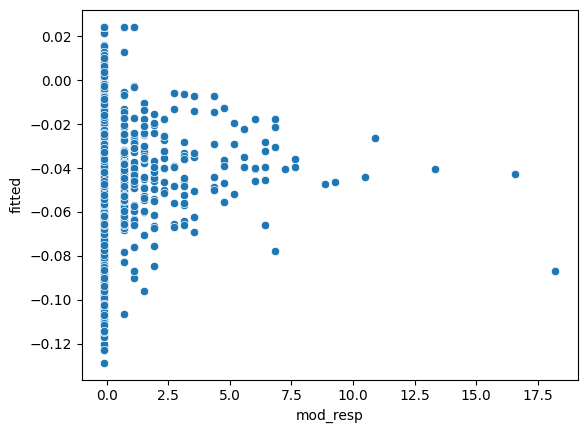

In [79]:
def fit_reg(arr_vals,site):
    #coefs = regs[site].coef_
    coefs = regs[site].coef_
    print(coefs)
    return np.sum(coefs * arr_vals,axis=1)

Tg_test_data = pd.DataFrame(train_data[train_data['site']=='Target'])
Tg_test_data['mod_resp'] = (Tg_test_data['review_helpful_votes'] - mu)/sig
Tg_test_data['mod_star'] = Tg_test_data['review_star_rating'] / 5
Tg_test_data['fitted'] = fit_reg(Tg_test_data[['review_subjectivity','review_polarity','mod_star']],site='Target')

sns.scatterplot(
    data=Tg_test_data,
    x='mod_resp',
    y='fitted'
)
plt.show()

# Tg_test_data['exp_review_subjectivity'] = dexp(Tg_test_data['review_subjectivity'])
# Tg_test_data['exp_review_polarity'] = dexp(Tg_test_data['review_polarity'])
# Tg_test_data['exp_prod_subjectivity'] = dexp(Tg_test_data['prod_subjectivity'])
# Tg_test_data['fitted_exp_reg'] = fit_reg(Tg_test_data[['exp_review_subjectivity','exp_review_polarity','exp_prod_subjectivity']],site='Target')
# #Tg_test_data['fitted_reg'] = fit_reg(test_data[test_data['site']=='Amazon'][['verified_purchase','review_subjectivity','review_polarity','prod_subjectivity']],'Amazon')

# sns.scatterplot(
#     data=Tg_test_data,
#     x='review_helpful_votes',
#     y='fitted_exp_reg'    
# )

              0
0      0.037987
1      0.037987
2      0.037987
3      0.037987
4      0.037987
...         ...
25402  0.004782
25403  0.004782
25404  0.004782
25405  0.004782
25406  0.004782

[25407 rows x 1 columns]


<Axes: xlabel='review_helpful_votes', ylabel='fitted'>

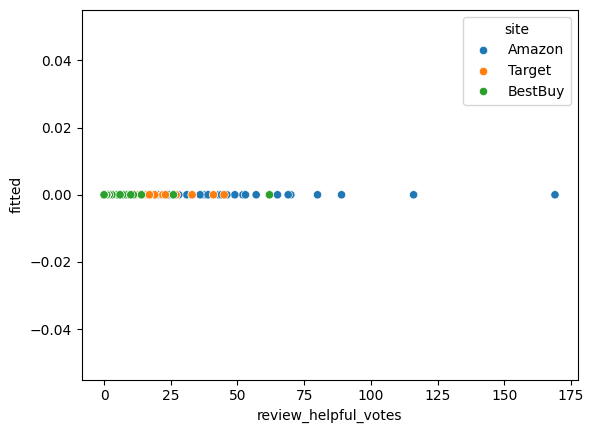

In [41]:
train_data['fitted'] = fit_reg(train_data[['review_length']],train_data['site'])#,'exp_review_subjectivity','exp_review_polarity']],train_data['site'])
sns.scatterplot(
    data=train_data,
    x='review_helpful_votes',
    y='fitted',
    hue='site'
)

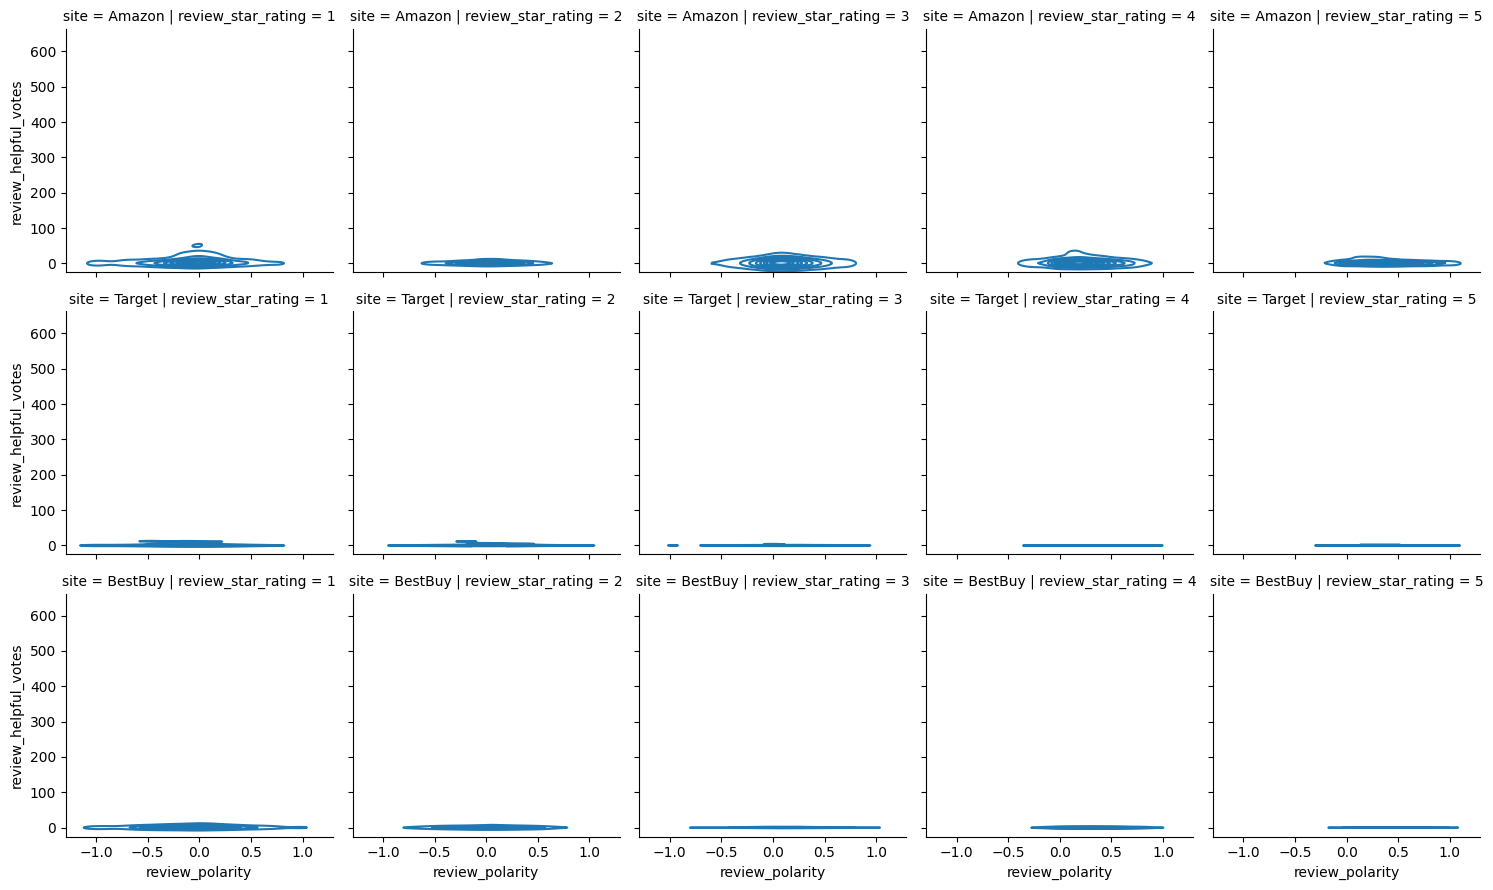

In [66]:
grid = sns.FacetGrid(
    data=review_data,
    col='review_star_rating',
    row='site'
)
grid.map_dataframe(
    sns.kdeplot,
    x='review_polarity',
    y='review_helpful_votes'
)
# sns.scatterplot(
#     data = train_data[train_data['review_star']],
#     x='review_subjectivity',
#     y='review_helpful_votes',
#     hue='review_star_rating'
# )

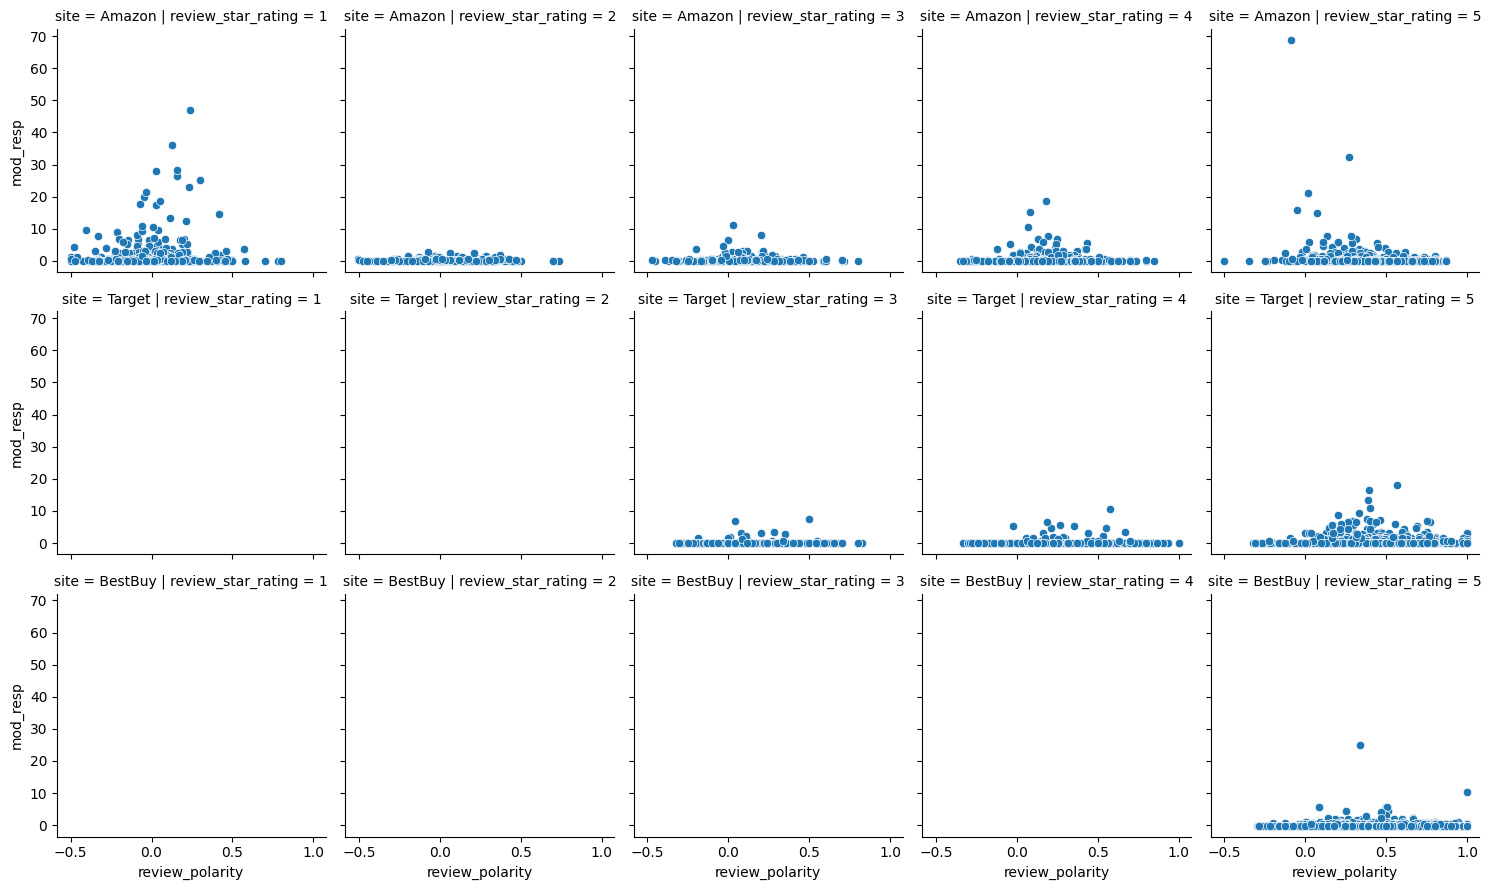

In [80]:
grid = sns.FacetGrid(
    data=train_data,
    col='review_star_rating',
    row='site'
)
grid.map_dataframe(
    sns.scatterplot,
    x='review_polarity',
    y='mod_resp'
)
grid.add_legend()

<Axes: xlabel='review_helpful_votes', ylabel='fitted_reg'>

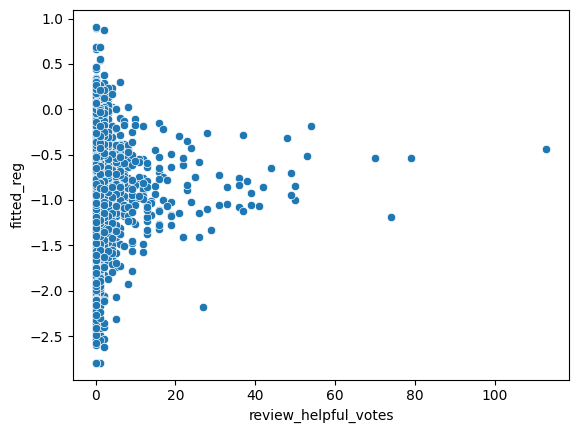

In [65]:
AZ_data = pd.DataFrame(review_data[review_data['site']=='Amazon'])
AZ_data['fitted_reg'] = fit_reg(AZ_data[AZ_data['site']=='Amazon'][['review_subjectivity','review_polarity','prod_subjectivity']],'Amazon')
sns.scatterplot(
    data=Tg_test_data,
    x='review_helpful_votes',
    y='fitted_reg'    
)

<Axes: xlabel='review_helpful_votes', ylabel='fitted_reg'>

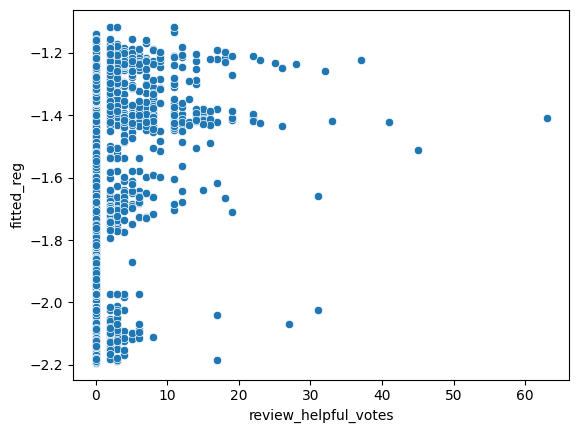

In [66]:
TG_data = pd.DataFrame(review_data[review_data['site']=='Target'])
TG_data['fitted_reg'] = fit_reg(TG_data[TG_data['site']=='Target'][['review_subjectivity','review_polarity','prod_subjectivity']],'Target')
sns.scatterplot(
    data=TG_data,
    x='review_helpful_votes',
    y='fitted_reg'    
)

In [18]:
from scipy import stats
temp_data = pd.DataFrame(train_data[train_data['site']=='Amazon'])
#u = 1 -np.exp((-np.mean(temp_data['review_helpful_votes']))*temp_data['review_helpful_votes'])
u = stats.expon.cdf(np.log(temp_data['review_helpful_votes']),scale=np.mean(temp_data['review_helpful_votes']))

c:\Users\pconn\miniconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: ylabel='Density'>

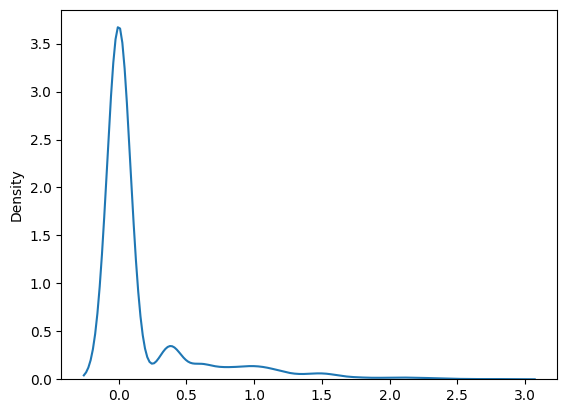

In [19]:

# display(np.mean(u),np.var(u))

# z= stats.norm.ppf(u)
# display(u.min(),u.max())
# sns.kdeplot(z)
z = stats.expon.ppf(u)
temp_data['norm_resp'] = z
sns.kdeplot(z)

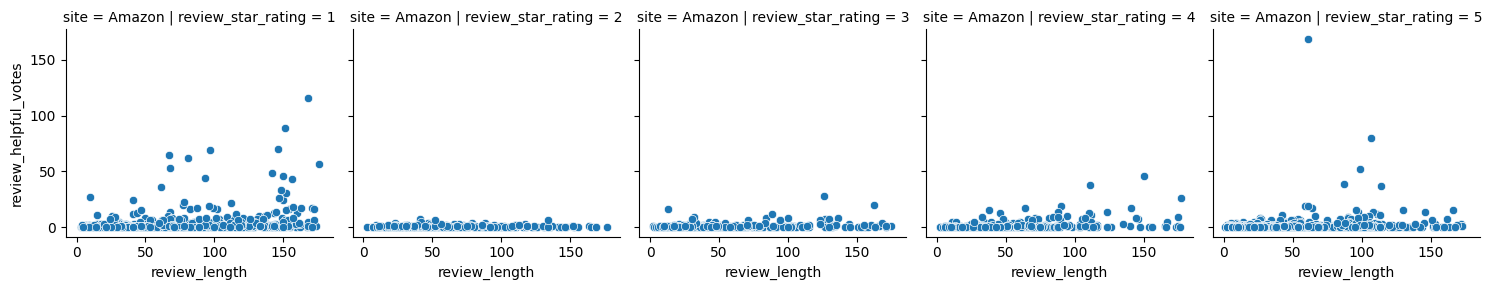

In [130]:
g = sns.FacetGrid(
    data= temp_data,
    col='review_star_rating',
    row='site'
)
g.map_dataframe(
    sns.scatterplot,
    x='review_length',y='review_helpful_votes'
)

In [124]:
temp_data.columns

Index(['Unnamed: 0', 'productID', 'prodSiteID', 'review_header',
       'reviewer_name', 'review_content', 'review_star_rating',
       'review_helpful_votes', 'verified_purchase', 'review_subjectivity',
       'review_polarity', 'review_length', 'url', 'review_lang', 'site',
       'site_outlier', 'site_outlier_en', 'global_outlier',
       'global_outlier_en', 'prod_subjectivity', 'exp_review_subjectivity',
       'exp_review_polarity', 'exp_prod_subjectivity', 'fitted', 'mod_resp',
       'mod_star', 'norm_resp'],
      dtype='object')

In [135]:
temp_data[np.abs(temp_data['norm_resp'])>3].value_counts(subset=['review_star_rating'])

review_star_rating
1                     83
5                     38
4                     28
3                     15
2                      3
Name: count, dtype: int64

In [136]:
temp_data[np.abs(temp_data['norm_resp'])>3][['review_subjectivity','review_polarity']].describe().T

,count,mean,std,min,25%,50%,75%,max
review_subjectivity,167.0,0.505815,0.128883,0.100000,0.422065,0.500000,0.585833,0.920000
review_polarity,167.0,0.101939,0.195878,-0.479167,-0.022430,0.086905,0.219922,0.614545


<Axes: xlabel='review_polarity', ylabel='norm_resp'>

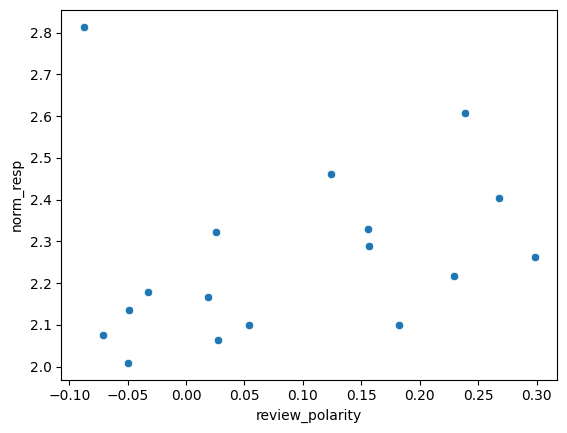

In [152]:
sns.scatterplot(
    data=temp_data[temp_data['norm_resp']>2.0],
    x='review_polarity',y='norm_resp'
)

<Axes: ylabel='review_helpful_votes'>

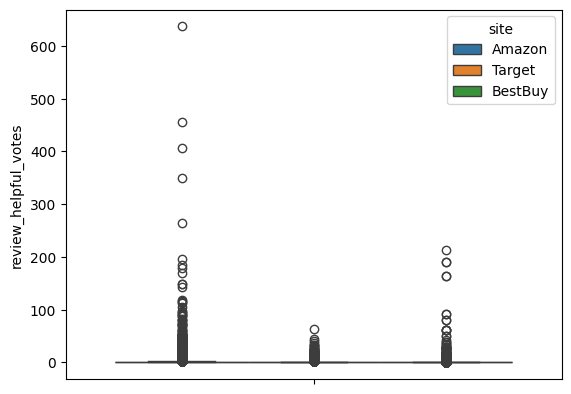

In [3]:
sns.boxplot(
    data = review_data,
    y='review_helpful_votes',
    hue='site'
)

In [4]:
review_data['review_helpful_votes'].describe().T

count    48081.000000
mean         0.522057
std          6.173165
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        637.000000
Name: review_helpful_votes, dtype: float64

In [6]:
review_data[review_data['review_helpful_votes']>0]['review_helpful_votes'].describe().T

count    4373.000000
mean        5.739995
std        19.726257
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max       637.000000
Name: review_helpful_votes, dtype: float64

<Axes: ylabel='review_helpful_votes'>

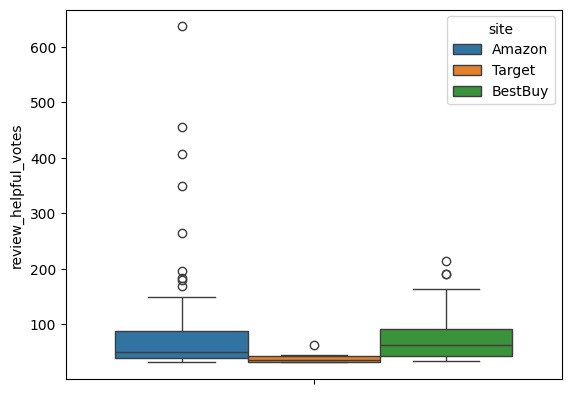

In [10]:
sns.boxplot(
    data = review_data[review_data['review_helpful_votes']>30],
    y='review_helpful_votes',
    hue='site'
)

In [17]:
sns.scatterplot(
    data = review_data[review_data['review_helpful_votes']>40],
    y='norm_resp',
    x='review_length'
)

ValueError: Could not interpret value `norm_resp` for `y`. An entry with this name does not appear in `data`.